### Montamos la unidad de drive - Importamos librerías y cargamos paths

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

from keras.utils import to_categorical
from keras import backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Input,LSTM
from keras.layers.core import Activation, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

import pandas as pd
import numpy as np

Mounted at /content/drive/


Using TensorFlow backend.


In [2]:
# Instalar librería para pinitar mapa
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 1s (91.9 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 134443 files and directories currently installed.)
Pr

In [0]:
# Cambiar esta línea al directorio de trabajo pertinente
files_path = "/content/drive/My Drive/HARVIS_UC2/BBDD/FR1193_Toulouse_Seville/"

# Se usarán para predecir la trayectoria final a utilizar para elegir el modelo de regresión
metar1_path = 'metar_1_clean.csv'  # Archivo con info metar1
metar2_path = 'metar_2_clean.csv'  # Archivo con info metar2

# Datos de trayectoria completos juntos en un mismo archivo
traj_path = 'trajectories.csv' 

# Archivo con información de las predicciones 
#gt_path = 'gt_data.csv'
model_path = 'models/'     

### Global variables and methods

In [3]:
# Cargamos datos
traj = pd.read_csv(files_path + traj_path, sep=",")
#gt = pd.read_csv(files_path + gt_path, sep=",")
pred_model = load_model(files_path+model_path+'metar_model.h5')
metar_1_clean = pd.read_csv(files_path+metar1_path, sep=",") # 30 minutos antes de aterrizaje
metar_2_clean = pd.read_csv(files_path+metar2_path, sep=",") # Momento de aterrizaje





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [4]:
import re
variables = ['hour', 'minute', 'second', 'altitude', 'direction', 'latitude', 'longitude', 'speed']
for v in variables:
  n = 0
  for i in traj[v]:  
    result = re.search('\[(.*)\]', i)
    traj[v][n] = [float(j) for j in result.group(1).split(',')]
    n +=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
# Normalizamos los datos de trayectoria respecto de los máximos y mínimos (no siguen una distribución gaussiana)
def normalize_data(x_data, min_value, max_value):
  # Normalizamos datos de entrada entre un mínimo y máximo para obtener un valor entre 0 y 1
  # x_data tiene shape = (samples, timestemps)
  x_diff = x_norm = np.zeros(x_data.shape)
  x_norm = (x_data-min_value)/(max_value-min_value)
  """for i in range(1,len(x_data)):
    x_diff[i] = x_norm[i]-x_norm[i-1]""" 
  return x_norm

# Denormalizar los datos para crear la predicción en valores (coordenadas y altitud) reales
def denormalize_data(norm_data, min_value, max_value):
  # Desormalizamos datos normalizados entre 0 y 1 para obtener entre mínimo y máximo 
  # x_data tiene shape = (samples, timestemps)
  x_diff = x_data = np.zeros(norm_data.shape)
  x_data = (norm_data*(max_value-min_value))+min_value
  """for i in range(1,len(x_data)):
    x_diff[i] = x_data[i]+x_data[i-1]""" 
  return x_data

# Estandarizamos los datos de metar respecto de la media y std de los datos de entrenamiento
def standarize_data(x_data):
  # Se utiliza la media y std de los datos de entrenamiento para estandarizar lso datos de test

  x_standarized = np.zeros(x_data.shape)

  for i in range(len(x_data.T)):
    std = np.std(x_data.T[i])
    if std ==0: std=1 # Si la std es 0, cambiamos por 1 para evitar dividir entre 0
    x_standarized.T[i] = (x_data.T[i]-np.mean(x_data.T[i]))/std
    
  return x_standarized

## TODO: modificar este método para que sea funcional en este caso y poder crear las particiones de test y train

# Mezclar datos de train y test y crear particiones
def shuffle_and_partition(x_traj, id_list, y, trainP):
  # x=inputs, y=outputs, trainP=porcentaje de train
  s = np.arange(x_traj.shape[0])
  np.random.shuffle(s)
  x_traj, id_list, y = x_traj[s], np.array(id_list)[s], y[s]

  # Asignamos particiones de train y test
  n_part = round(trainP*len(x_traj))

  x_traj_train, x_traj_test, id_list_train, id_list_test, y_train, y_test = x_traj[:n_part], x_traj[n_part:], id_list[:n_part], id_list[n_part:], y[:n_part], y[n_part:]
  return x_traj_train, x_traj_test, id_list_train, id_list_test, y_train, y_test

### Tratamiento datos de trayectoria

Pasamos las variables a formato float y hacemos el cambio de coordenadas

In [0]:
#cambio de coordenadas [latitud,longitud,altitud] -> [x,y,z]
x_coord,y_coord,z_coord = list(),list(),list()
a = 1378.137
b = 6356.752
e1 = (a**2 - b**2)/a**2
for i in range(len(traj['longitude'])):
  Nr = a/(1-e1*(np.sin(np.deg2rad(traj['longitude'][i])))**2)**0.5
  x_coord.append((Nr*(1-e1)+traj['altitude'][i])*np.sin(np.deg2rad(traj['longitude'][i])))
  y_coord.append((Nr+traj['altitude'][i])*np.cos(np.deg2rad(traj['longitude'][i]))*np.cos(np.deg2rad(traj['latitude'][i])))
  z_coord.append((Nr+traj['altitude'][i])*np.cos(np.deg2rad(traj['longitude'][i]))*np.sin(np.deg2rad(traj['latitude'][i])))
  #x.append()
fl_id_list = list(traj['fl_id'])
threshold = list(traj['threshold'])

In [0]:
maxz_coord = list()
for i in range(len(z_coord)):
  maxz_coord.append(max(z_coord[i]))
print(max(maxz_coord))

28687.12225097063


In [0]:
# Separar una serie de datos secuenciales de una sola variable en muestras diferentes y la salida - Preparación para LSTM univariate
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps # Fin de secuencia
		if end_ix > len(sequence)-1: # Comprobar si hemos rebasado el final
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # Separar entre entrada y salida
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [0]:
import numpy as np
# Separar una serie de datos secuenciales de una varas variables en muestras diferentes y la salida - Preparación para LSTM multivariate
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

### Univariate CNN LSTM

In [0]:
#Hyperparameters
batch_size = 64
epochs = 50
validation_split = 0.2
n_features = 1
n_steps = 1
n_seq = 1
n_steps_xseq = int(n_steps/n_seq)
lr = 0.0001

Train on 35016 samples, validate on 8755 samples
Epoch 1/50
35016/35016 [==============================] - 5s 146us/step - loss: 0.0295 - val_loss: 5.3092e-04
Epoch 2/50
35016/35016 [==============================] - 3s 84us/step - loss: 4.6549e-04 - val_loss: 3.7201e-04
Epoch 3/50
35016/35016 [==============================] - 3s 84us/step - loss: 3.8316e-04 - val_loss: 3.4491e-04
Epoch 4/50
35016/35016 [==============================] - 3s 87us/step - loss: 3.7951e-04 - val_loss: 3.4991e-04
Epoch 5/50
35016/35016 [==============================] - 3s 86us/step - loss: 3.7926e-04 - val_loss: 3.4241e-04
Epoch 6/50
35016/35016 [==============================] - 3s 86us/step - loss: 3.8022e-04 - val_loss: 3.4836e-04
Epoch 7/50
35016/35016 [==============================] - 3s 90us/step - loss: 3.8154e-04 - val_loss: 3.5267e-04
Epoch 8/50
35016/35016 [==============================] - 3s 86us/step - loss: 3.8389e-04 - val_loss: 3.8787e-04
Epoch 9/50
35016/35016 [==========================

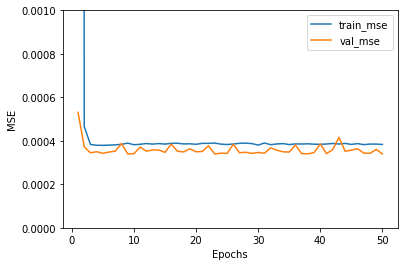

In [19]:
#CNN LSTM univariate model
import numpy as np
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing import sequence
from keras.layers import Dense
from keras import optimizers
import matplotlib.pyplot as plt

X, Y = np.zeros([0,n_steps]), np.zeros([0,n_steps])
for i in range(len(traj)):
  data = normalize_data(np.array(traj['altitude'][i]), 0, 40000)
  x1, y1 = split_sequence(data, n_steps)
  X = np.insert(X, len(X), x1, axis=0)
  Y = np.append(Y, y1)

# Reshape para introducri en red LSTM
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
X = X.reshape((X.shape[0], n_steps, n_features))

#Define model
model = Sequential()
model.add(LSTM(60,kernel_initializer = 'glorot_normal',activation = 'elu',return_sequences = True,recurrent_dropout=0.2))
model.add(LSTM(30,kernel_initializer = 'glorot_normal',activation = 'elu',recurrent_dropout=0.2))
model.add(Dense(n_features))
model.compile(optimizer=optimizers.Adam(decay = lr/epochs,clipvalue = 1), loss='mse')

# fit model
H = model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_split= 0.2,verbose=1)

train_loss = H.history['loss']
validation_loss = H.history['val_loss']
plt.plot(range(1, len(train_loss) + 1),train_loss)
plt.plot(range(1, len(validation_loss) + 1),validation_loss)
plt.xlabel('Epochs')
plt.legend(['train_mse','val_mse'])
plt.ylabel('MSE')
plt.ylim(0,0.001)
plt.show()

#Save model
#model.save(files_path+model_path+'uv_CNN_model.h5')

In [25]:
pred

NameError: ignored

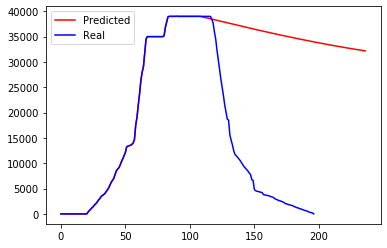

In [20]:
# demonstrate prediction
tr_id = 1

pred_alt = list()

input_alt = normalize_data(np.array(traj['altitude'][tr_id][threshold[tr_id]-n_steps:threshold[tr_id]]), 0, 40000)

dataset= np.array([input_alt])
x_input = dataset.reshape((1,n_steps,n_features))

#Cargamos modelo
#model = load_model(files_path+model_path+'uv_CNN_model.h5')

# Elegimos el modelo según la trayectoria

for i in range(abs(len(traj['altitude'])-threshold[tr_id])):
  pred = model.predict(x_input, verbose=0)

  pred_alt.append(pred[0][0])
  x_input = np.array(pred[0][0])
  x_input = x_input.reshape((1, n_steps,n_features))

pred_alt = denormalize_data(np.array(pred_alt),0, 40000)
init_alt = np.array(traj['altitude'][tr_id][:threshold[tr_id]])
output_alt = np.concatenate([init_alt, pred_alt])

labels = ['Predicted', 'Real']

plt.plot(output_alt, 'r')
plt.plot(traj['altitude'][tr_id], 'b')
#plt.ylim(0,40000)
plt.legend(labels)
plt.show()